In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
train_path = '../data/train_images_split/train'

In [3]:
val_path = '../data/train_images_split/val'

In [4]:
test_path = '../data/test_images'

In [5]:
X_train = []
x = 0
for folder in os.listdir(train_path):
    
    sub_path= train_path + '/' + folder
    
    for img in os.listdir(sub_path):
        image_path = sub_path + '/' + img
        img_arr = cv2.imread(image_path)
        img_arr = cv2.resize(img_arr, (32,32))
        X_train.append(img_arr)
        x += 1
        print(x, end='\r')

In [65]:
X_test = []
x = 0
for img in os.listdir(test_path):
    
    image_path = test_path + '/' + img
    img_arr = cv2.imread(image_path)
    img_arr = cv2.resize(img_arr, (32,32))
    X_test.append(img_arr)
    x += 1
    print(x, end='\r')

In [7]:
X_val = []
x = 0
for folder in os.listdir(val_path):
    sub_path = val_path + '/' + folder
    
    for img in os.listdir(sub_path):
        image_path = sub_path + '/' + img
        img_arr = cv2.imread(image_path)
        img_arr = cv2.resize(img_arr, (32,32))
        X_val.append(img_arr)
        x += 1
        print(x, end = '\r')
        
    

In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [9]:
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (32,32),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (32,32),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (32,32),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 8323 images belonging to 10 classes.
Found 0 images belonging to 0 classes.
Found 2084 images belonging to 10 classes.


In [14]:
y_train=training_set.classes
y_test=test_set.classes
y_val=val_set.classes

In [15]:
training_set.class_indices

{'bacterial_leaf_blight': 0,
 'bacterial_leaf_streak': 1,
 'bacterial_panicle_blight': 2,
 'blast': 3,
 'brown_spot': 4,
 'dead_heart': 5,
 'downy_mildew': 6,
 'hispa': 7,
 'normal': 8,
 'tungro': 9}

In [16]:
y_train.shape,y_test.shape,y_val.shape

((8323,), (0,), (2084,))

In [17]:
X_train.shape[1]

32

In [19]:
vgg = VGG19(input_shape = (32, 32, 3), weights = 'imagenet', include_top = False)

In [20]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [21]:
x = Flatten()(vgg.output)

In [22]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(10, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [23]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [24]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [26]:
# fit the model
history = model.fit(
  X_train,
  y_train,
  validation_data=(X_val,y_val),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
261/261 [==============================] - 39s 146ms/step - loss: 2.0375 - accuracy: 0.2777 - val_loss: 1.9634 - val_accuracy: 0.2965
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 1.8811 - accuracy: 0.3467 - val_loss: 1.8663 - val_accuracy: 0.3325
Epoch 3/10
261/261 [==============================] - 55s 212ms/step - loss: 1.8134 - accuracy: 0.3686 - val_loss: 1.8242 - val_accuracy: 0.3685
Epoch 4/10
261/261 [==============================] - 56s 213ms/step - loss: 1.7670 - accuracy: 0.3857 - val_loss: 1.7855 - val_accuracy: 0.3762
Epoch 5/10
261/261 [==============================] - 55s 211ms/step - loss: 1.7326 - accuracy: 0.3977 - val_loss: 1.7548 - val_accuracy: 0.3834
Epoch 6/10
261/261 [==============================] - 55s 212ms/step - loss: 1.7013 - accuracy: 0.4115 - val_loss: 1.7354 - val_accuracy: 0.3949
Epoch 7/10
261/261 [==============================] - 55s 212ms/step - loss: 1.6765 - accuracy: 0.4232 - val_loss: 1.7185 - val_ac

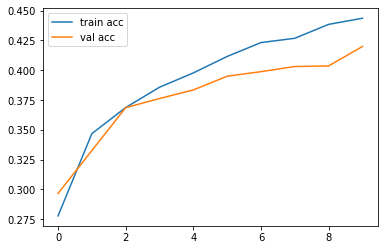

In [27]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

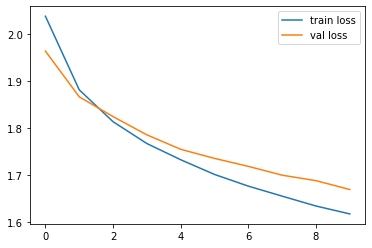

In [28]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [49]:
# model.evaluate(X_test,y_val,batch_size=32)

In [50]:
# predict

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [86]:
submission = pd.read_csv('../data/sample_submission.csv')

In [87]:
submission['label'] = y_pred

In [96]:
training_set_values = training_set.class_indices.keys()

In [97]:
training_set_keys = training_set.class_indices.values()

In [100]:
training_set_reversed = dict(zip(training_set_keys, training_set_values))

In [101]:
training_set_reversed

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [103]:
submission['label'] = submission['label'].map(training_set_reversed)

In [104]:
submission

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,hispa
3,200004.jpg,brown_spot
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,normal
3466,203467.jpg,brown_spot
3467,203468.jpg,bacterial_panicle_blight


In [63]:
submission.to_csv('../data/submission.csv', index = False)